<a href="https://colab.research.google.com/github/PedroDubas/Captcha_recognition/blob/master/Captcha_Recognizer_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Download Exemplos com Label [Link](https://github.com/PedroDubas/Captcha_recognition/blob/master/samples.zip)


In [1]:
#Download dos Captchas
import urllib.request

url = 'https://github.com/PedroDubas/Captcha_recognition/raw/master/samples.zip'
urllib.request.urlretrieve(url, '/content/samples.zip')


('/content/samples.zip', <http.client.HTTPMessage at 0x7fe9cd1abfd0>)

In [0]:
!unzip -q samples.zip 

##Imports

In [3]:
import cv2
from skimage.transform import  resize
import pandas as pd
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Criar um "Esqueleto" para receber os 784 Pixeis da imagem (28 x 28) + 1 campo para ser o Y do nosso modelo

In [0]:
lista_coluna =['label']
for numero in range(0,784):
    lista_coluna.append('pixel'+str(numero))

treino = pd.DataFrame(columns=lista_coluna)

fulldata = treino.copy()

In [0]:
def trataImagem(caminho,treino):
    img = cv2.imread(caminho, 0)

    blur = cv2.GaussianBlur(img, (5, 5), 0)
    thre = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(thre, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)
    
    kernel = np.ones((3,1), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations=1)


    #Posicionamento para pegar as letras individualmente da imagem
    x, y, w, h = 30, 12, 21, 36
    idx=0
    for  i in range(5):        
        crop_img = dilation[y:y+h, x:x+w]
        
        #Altera o tamanho dos cortes para 28x28 um tamanho fixo, e mais facil para nossa rede trabalhar em cima mais tarde.
        image_resized = resize(crop_img, (28.0, 28.0),anti_aliasing=True).astype("int32") 
        rows,cols = image_resized.shape 
        img_size = rows*cols
        
        #Converte a imagem antes em uma Matrix, para um arrey de 784 posicoes
        img_1D_vector = image_resized.reshape(img_size)
        lista = img_1D_vector.tolist()
        lista.insert(0,str(caminho[-9:][i]))
        
        new_row = pd.DataFrame(columns=treino.columns,data=[lista]) 
        treino = treino.append(new_row,ignore_index=True)   
        x += w
        idx +=1
    return treino

![alt text](https://github.com/PedroDubas/Captcha_recognition/blob/master/image.png?raw=true)

[Leia mais](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html)

In [6]:
path = 'samples'

files = [f for f in glob.glob(path + "**/*.png", recursive=True)]
idx=0
for file in files:
    fulldata = fulldata.append(trataImagem(file,treino),ignore_index=True)
    idx+=1
    if idx % 10 ==0 : print(idx)  #Total: 1070

10


Exibe algumas amostras

In [9]:
fulldata.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,y,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,g,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
2,f,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,w,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,e,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,8,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,f,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,e,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,x,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,n,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


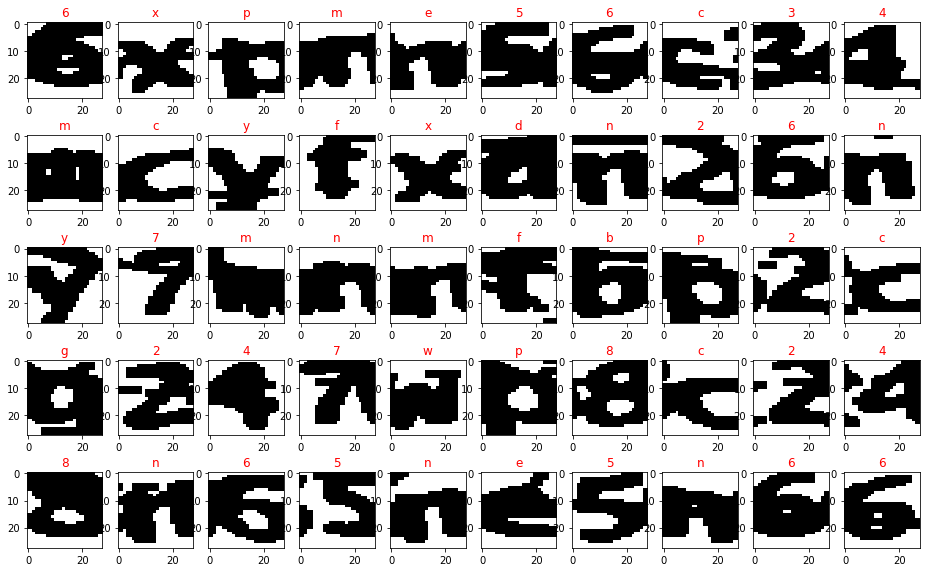

In [0]:
numeros = fulldata

X = (numeros.iloc[:,1:].values).astype('float32') # all pixel values
y = numeros.iloc[:,0].values

x_img = X.reshape(X.shape[0], 28, 28)

plt.figure(figsize = (16,10))
for i in range(0, 50):
    plt.subplot(5,10,0 + (i+1))
    plt.imshow(x_img[i], cmap=plt.get_cmap('gray'))
    plt.title(y[i],color='r');

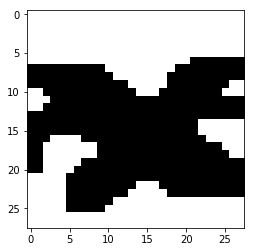

In [0]:
X_train = X.reshape(-1,28,28,1)
g = plt.imshow(X_train[1][:,:,0],'gray')

Transformando o Y em Categorico

In [0]:
y2 = pd.get_dummies(y)
target_labels = y2.columns
target = y2.as_matrix().astype("float32")

##Dividir entre Treino(80%) Teste(10%) Validacao(10%)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train.astype('int32'), target, test_size=0.2, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('Full Data',X.shape)
print('X_Train',X_train.shape)
print('X_test',X_test.shape)
print('X_val',X_val.shape)

Full Data (5200, 784)
X_Train (4160, 28, 28, 1)
X_test (520, 28, 28, 1)
X_val (520, 28, 28, 1)


##Resultado do Target Categorizado

In [0]:
print(target_labels)
print(target[1])

Index(['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm',
       'n', 'p', 'w', 'x', 'y'],
      dtype='object')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


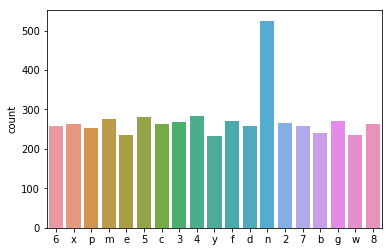

In [0]:
g = sns.countplot(y)
#g = sns.countplot(y_train)
#g= sns.countplot(y_val)

##Criacao da Rede

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
#model.add(Dense(10, activation = "softmax"))
model.add(Dense(19, activation = "softmax"))


In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

mcp_save = ModelCheckpoint('melhor.hdf5', save_best_only=True, monitor='val_acc', mode='auto', verbose=1)


In [0]:
epochs = 30
batch_size = 86

In [0]:
datagen.fit(X_train)

In [0]:
history=''

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,mcp_save])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
48/48 [==============================] - 8s 175ms/step - loss: 2.2155 - acc: 0.3365 - val_loss: 1.0287 - val_acc: 0.7577

Epoch 00001: val_acc improved from -inf to 0.75769, saving model to melhor.hdf5
Epoch 2/50
48/48 [==============================] - 2s 38ms/step - loss: 1.2967 - acc: 0.6274 - val_loss: 0.7409 - val_acc: 0.8250

Epoch 00002: val_acc improved from 0.75769 to 0.82500, saving model to melhor.hdf5
Epoch 3/50
48/48 [==============================] - 2s 37ms/step - loss: 0.9978 - acc: 0.7096 - val_loss: 0.5937 - val_acc: 0.8442

Epoch 00003: val_acc improved from 0.82500 to 0.84423, saving model to melhor.hdf5
Epoch 4/50
48/48 [==============================] - 2s 37ms/step - loss: 0.8098 - acc: 0.7620 - val_loss: 0.5110 - val_acc: 0.8635

Epoch 00004: val_acc improved from 0.84423 to 0.86346, saving model to melhor.hdf5
Epoch 5/50
48/48 [==============================] - 2s 37ms/step - loss: 0.7153 - acc: 0.7888 - val_loss: 0.4575 - val_acc: 0.8423

Epoch 0000

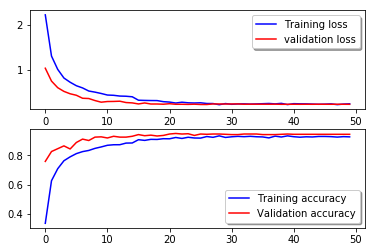

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (7,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Matriz de confusao

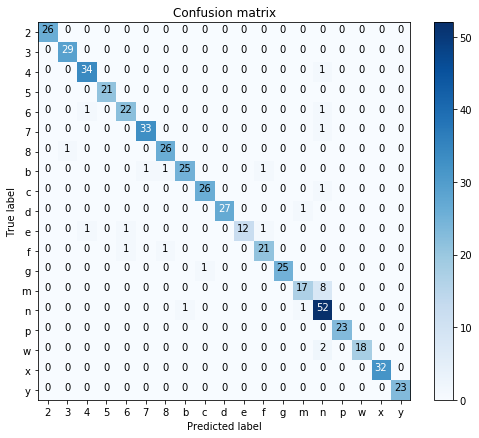

In [0]:
Y_pred = model.predict(X_test)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = target_labels)

#Rede TREINADA!

=========================================

Para ler os Capthas com a rede treinada use esse Script [Aqui](https://github.com/PedroDubas/Captcha_recognition/blob/master/Captcha_Recognizer_PLAY.ipynb)
